In [1]:
# import findspark
# findspark.init('/home/ubuntu/spark')
import pyspark
sc = pyspark.SparkContext(appName="averageAgeToAct")

In [2]:
spark = (pyspark.sql.SparkSession
         .builder        
         .appName('averageAgeToAct')
         .getOrCreate()
        )

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('ggplot')

def transform_to_df(path, sep_input="\t"):
    return spark.read.csv(path,
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=sep_input,           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [9]:
movies_raw = transform_to_df("movies.csv", ",")

In [10]:
movies_raw.registerTempTable("movies_raw")

In [22]:
sparkTable = spark.sql(
"""
SELECT DISTINCT titleId, startYear FROM movies_raw
"""
)
pd_filtered_movie = sparkTable.toPandas()

In [26]:
pd_filtered_movie.to_csv("/home/ubuntu/jupyter/movie_year.csv", sep="\t")

In [4]:
actors_raw = transform_to_df("name.basics.tsv", "\t")
actors_raw.registerTempTable("actors_raw")

In [5]:
actors_raw.printSchema()

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)



In [6]:
sparkTable = spark.sql(
"""
SELECT DISTINCT nconst, birthYear,primaryProfession FROM actors_raw WHERE (primaryProfession LIKE '%actor%') or (primaryProfession LIKE '%actress%')
"""
)

In [7]:
pd_filtered_people = sparkTable.toPandas()

In [8]:
pd_filtered_people.to_csv("/home/ubuntu/jupyter/people_year.csv", sep="\t")

In [9]:
movies = transform_to_df("/home/ubuntu/jupyter/movie_year.csv", "\t")

In [18]:
movies.registerTempTable("movies")

In [11]:
people = transform_to_df("/home/ubuntu/jupyter/people_year.csv", "\t")

In [19]:
people.registerTempTable("people")

In [16]:
principals = transform_to_df("/home/ubuntu/jupyter/principals.csv", ",")

In [20]:
principals.registerTempTable("principals")

In [50]:
sparkTable = spark.sql(
"""
SELECT pid, birthYear, primaryProfession,  startYear FROM (
    SELECT * FROM (
        SELECT * FROM 
            (SELECT nconst as pid, * FROM people WHERE birthYear NOT LIKE "%N%") as T1 
            JOIN principals ON principals.nconst = T1.nconst
        ) as T2
        JOIN movies ON movies.titleId = T2.tconst
    )
"""
)

In [51]:
final_data = sparkTable.toPandas()

In [52]:
final_data.to_csv("/home/ubuntu/jupyter/actor_age.csv", sep="\t")

In [5]:
import pandas as pd
# df = pd.read_csv("/home/ubuntu/jupyter/actor_age.csv", sep="\t")
df = pd.read_csv("IMDb_datasets/actor_age.csv", sep="\t")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df.drop("Unnamed: 0", axis=1)

In [7]:
df = df[df.startYear != "\\N"]

In [8]:
df["age"] = df["startYear"].astype("int64") - df['birthYear'].astype("int64")

In [9]:
actors = df[df["primaryProfession"].apply(lambda x: 'actor' in x )]
actors.size

487240

In [6]:
df.size

710700

In [10]:
actresses = df[df["primaryProfession"].apply(lambda x: 'actress' in x )]
actresses.size

223460

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

In [12]:
actors = actors.groupby("startYear").mean()
actresses = actresses.groupby("startYear").mean()

In [13]:
#actresses = actresses.drop("startYear", axis=1)
actresses = actresses.reset_index()
actresses["startYear"] = actresses["startYear"].astype('int64')
actresses = actresses.sort_values(by=['startYear'])
# actresses
# 

In [14]:
actors = actors.reset_index()
actors["startYear"] = actors["startYear"].astype('int64')
actors = actors.sort_values(by=['startYear'])

In [15]:
all_people = df.reset_index()
all_people = all_people[["startYear", "age"]]
# all_people

In [16]:
all_people['startYear'] = all_people['startYear'].astype('int64')

In [17]:
all_people = all_people.groupby('startYear').mean()

In [18]:
all_people = all_people.reset_index()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

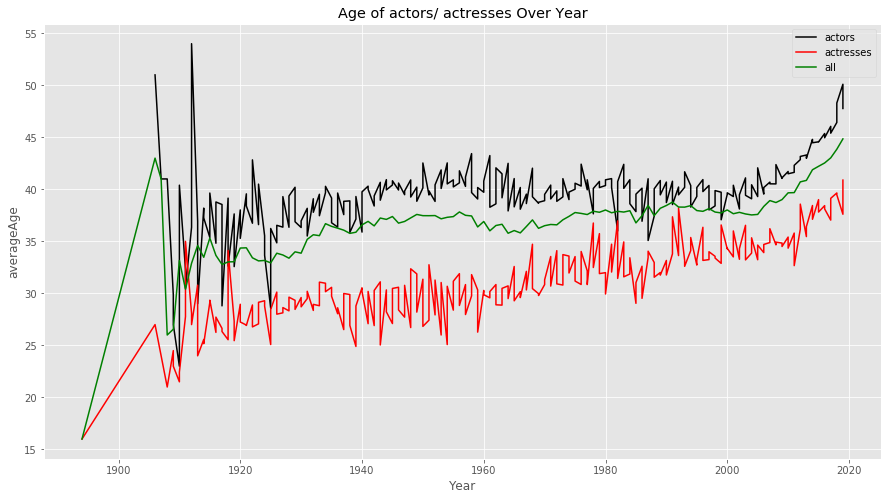

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Age of actors/ actresses Over Year")
ax.set_ylabel("averageAge")
ax.set_xlabel("Year")

plt.plot(actors["startYear"], actors["age"], 'k', label="actors")
plt.plot(actresses["startYear"], actresses["age"], 'r', label="actresses")
plt.plot(all_people["startYear"], all_people["age"], 'g', label="all")
plt.legend(loc='best')
plt.savefig('age_over_year.png')
plt